# Sentiment analsysis based on lexical dictionaries

This code allows you to perform Lexicon-Based Sentiment analysis. Based on an original work in https://github.com/jvas28/sentec 
using ecuatorian lexicon, the corpus has been updated with specific bag/good expressions determined by OFFCORSS surveys. Likewise, lexicon is been complemented using the englist-to-spanish translation of the SentiWordNet v3.0.0 (1 June 2010) dataset (https://github.com/aesuli/SentiWordNet).

- For the SentiWordNet dataset, the sentiment score is determined by computing PosScore	- NegScore. (This number is determined between -1 and 1, where -1 is categorized as mostly bad and 1 mostly good)

- For the custom lexicon, the sentiment score has been given in a 1-5 scale, where 1 is categorized as mostly bad and 5 mostly good. Then, the score is standarized to be in the interval [-1, 1] to be conststent with the SentiWordNet dataset

- A working lexicon is created from these two datasets. Only one instance is kept from any repeadted word maintaining the last instance in the dataset. 


The commments are tokenized, and stopwords removed form the lists. The unigrams, bigrams and trigrams and then scored based on the joined lexicon. For words not located in the lexicon, a score of 0 is assigned

The features computed were: the mean score of tokens, the total sum of tokens, the total length of the comment, the maximum score for the tokens in the comment. 

Finally, we tried four classifiers to predict the probability to be in a specific class (bad/good). The ROC curves were finally conmpared


---

## Import packages

In [1]:
# Load packages
import nltk # imports the natural language toolkit
nltk.download('punkt')
nltk.download('stopwords')
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import string
import re
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from pylab import rcParams
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import plotly.express as px
import nltk
from wordcloud import WordCloud
import os
from   scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pylab
import math 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sapmn3\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sapmn3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
from data_exploring.data_exploring_functions import *


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sapmn3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This code below is based on functions from from https://github.com/jvas28/sentec 

In [3]:
# code from https://github.com/jvas28/sentec 
#           Sentec - Análisis de Sentimiento en Ecuador

#from sentec.src import es_nlp as lang_tools ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
# Using the code directly:

import nltk  
from nltk.corpus import stopwords  
from nltk import word_tokenize  
from nltk.stem import SnowballStemmer  
from string import punctuation  
stopwords=stopwords.words('spanish')
# inicializar el extractor de raices lexicales
stemmer = SnowballStemmer('spanish')
# inicializar la lista de palabras ignoradas 
non_words = list(punctuation)  
# agregar a la lista los signos de apertura y los digitos [1-9]
non_words.extend(['¿', '¡'])  
non_words.extend(map(str,range(10)))

# funcion de extraccion de raices lexicales
def stem(word):
    return stemmer.stem(word)

# funcion de extraccion de raices lexicales sobre una lista
def stem_tokens(tokens):  
    stemmed = []
    for item in tokens:
        stemmed.append(stem(item))
    return stemmed

# funcion de disgregacion de palabras 
'''
    Separa las palabras y construye expresiones multipalabras
'''
def tokenize(text):  
    qgrams=[];
    trigrams=[];
    bigrams=[];
    text=text.lower()
    text = ''.join([c for c in text if c not in non_words])
    unigrams =  word_tokenize(text)
    #tokens = [t for t in tokens if t not in stopwords]
    if len(unigrams)>1:
        bigrams=[ x.lower()+" "+y.lower() for (x,y) in zip(unigrams,unigrams[1:])]
    if len(unigrams)>2:
        trigrams=[ x.lower()+" "+y.lower() for (x,y) in zip(bigrams,unigrams[2:])]
    if len(unigrams)>3:
        qgrams=[ x.lower()+" "+y.lower() for (x,y) in zip(trigrams,unigrams[3:])]
    tokens=qgrams+trigrams+bigrams+unigrams
    tokens = stem_tokens(tokens)
    return tokens

#from sentec.src ::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

#from sentec.src.classifier import nbclassifier,known_words,extract_feature
# Using the code directly:

import nltk
import pickle
import os
# Del modulo creado en la Parte I del microcurso importamos la funcion stem
#from es_nlp import stem
#from sentec.src import es_nlp as stem

# Declaramos las las rutas de los archivos de lexico y clasificador
classifier_file="./sentec/res/train/classifier.pickle"
lexicon_file="./sentec/res/lexicon/sdal_lexicon.csv"


# funcion para extraer caracteristicas para el clasificador
#def extract_feature(w):
#    return {"word":w}

# funcion que construye el set para entrenamiento del algoritmo clasificador
# lexico para el entrenamiento
#lexicon_lines=open(lexicon_file,"r", encoding='utf-8').readlines();
#labeled_words=[]
#known_words=[]
#for line in lexicon_lines:
#    split=line.replace("\n","").split(";")
#    word=split[0].split("_")
#    word=stem(word[0])
#    known_words.append(word)
#    labeled_words.append((word,split[1]))
#feature_set=[(extract_feature(n), sentiment) for (n, sentiment) in labeled_words]

# Para evitar crear y entrenar el clasificador una y otra vez
# usamos pickle para grabar el objeto entrenado como archivo binario
#if not (os.path.isfile(classifier_file)):
#    nbclassifier = nltk.NaiveBayesClassifier.train(feature_set)
#    f = open(classifier_file, 'wb')
#    pickle.dump(nbclassifier, f)
#    f.close();
#else:
#    f = open(classifier_file, 'rb')
#    nbclassifier = pickle.load(f)
#    f.close()

In [4]:
# Define functions for text processing
from sklearn.feature_extraction.text import CountVectorizer
import re
nltk.download('stopwords')
from nltk.corpus import stopwords

# stop words should be updated to accept important words in our context (mostly for bigrams and trigrams)
nostopwords  = ['no','muy','pero','eso']
stopWords_ls = stopwords.words("spanish")
stopWords_ls = [word for word in stopWords_ls if word not in nostopwords]

def words_to_ngrams(words, n, sep=" "):
    ngrams = [sep.join(words[i:i+n]) for i in range(len(words)-n+1)]
    return  ngrams

def get_unique_tokens(comment_ls):

    words_ls = []
    
    for text in comment_ls:
        text  = " ".join(re.findall("[a-zA-Z]+", text))
        words =  word_tokenize(text)
        words = [word for word in words if word not in stopWords_ls]
        
        words_ls.append(list(set(words)))
        
    words_ls = [item for sublist in words_ls for item in sublist]    
     
    return list(set(words_ls))

def get_tokenized(text):
    words =  word_tokenize(text)
    #words = [str.strip(word) for word in words if word not in stopWords_ls]
    words = [str.strip(word) for word in words if word not in stopWords_ls]
    #word = re.compile('\w+').findall(word)
    # get ngrams
    ugrams = words_to_ngrams(words,1)
    bgrams = words_to_ngrams(words,2)
    tgrams = words_to_ngrams(words,3)
    
    ngrams = [ugrams,bgrams,tgrams]
    
    return  [item for sublist in ngrams for item in sublist]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sapmn3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Define features for classification
def get_comment_features(test_comment):

    test_comment = test_comment.replace(" . ", " ").replace(" , ", " ").replace(" .", "")

    tokens = get_tokenized(test_comment)
    #print(test_comment)
    tokens = stem_tokens(tokens)

    elem_scores = []
    scores_vals = []

    for cur_word in tokens:
        if cur_word in known_words['stem'].values:
            element  = known_words[known_words['stem'] == cur_word]
            cur_score = element.score.values[0] 
        else:
            cur_score = 0

        elem_scores.append((cur_word,cur_score))
        scores_vals.append(cur_score)

    if len(scores_vals) > 0 :   
        features_comment = [sum(scores_vals) / len(scores_vals),sum(scores_vals),len(scores_vals), min(scores_vals), max(scores_vals)]
    else:
        features_comment = [0,0,0,0,0]
        
    #print(features_comment)
    #elem_scores
    
    return features_comment

Define functions for training and test of classifiers:

In [6]:
# generate cross-validated ROC and AUC for logistic regression model

from sklearn import ensemble, svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from statsmodels.formula.api import ols
from sklearn.naive_bayes import GaussianNB, MultinomialNB

def cv_roc_logit(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        logit = sm.Logit(y.iloc[train].astype('float64'), X.iloc[train].astype('float64'))
        logit_res = logit.fit(disp=0)
        probas_ = logit_res.predict(X.iloc[test])
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

def cv_roc_nb(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        
        gnb = GaussianNB()
        gnb.fit( X.iloc[train].astype('float64'), y.iloc[train].astype('float64'))
        probas_ = gnb.predict_proba(X.iloc[test])
        
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

def cv_roc_rf(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        
        
        clf  = ensemble.RandomForestClassifier(n_estimators = 250)
        clf  = clf.fit(X.iloc[train].astype('float64'), y.iloc[train].astype('float64'))
        probas_ = clf.predict_proba(X.iloc[test])
                
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

def cv_roc_svm(X, y, n_split):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    

    for train, test in cv.split(X, y):
        
        
        clf = svm.SVC(kernel='linear', probability=True,
                      random_state = 0)
        clf.fit(X.iloc[train].astype('float64'), y.iloc[train].astype('float64'))
        
        probas_ = clf.predict_proba(X.iloc[test])
                
        # Compute ROC curve and area under the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

----

## Load data:

In [7]:
# Load preprocessed data from surveys
base_datapath = 'C:\\Users\\sapmn3\\Database\\OFFCORSS\\data\\data_clean'

load_file = 'offcorss_sentiment'
load_path = os.path.join(base_datapath, load_file + '.csv')
data_responses = pd.read_csv(load_path)
data_responses = data_responses.drop(columns=['Unnamed: 0'])
data_responses.head()

,index,Requester,User Id,Email,Ticket Id,Brand,Group,Assignee,Satisfaction,Comment,Survey Date,processed comment
0,2242,alejo.datenshi,374298422771,alejo.datenshi@gmail.com,416857,OFFCORSS,Call Center,VENTAS TIENDA VIRTUAL,good,NaN,2019-01-01,NaN
1,2245,Carime Suarez,1871267083,luzkarinasuarez1980@hotmail.com,421812,OFFCORSS,Tienda Virtual,Servicio al cliente TV,good,NaN,2019-01-01,NaN
2,2244,marketsevenstar,374852675191,marketsevenstar@gmail.com,421796,OFFCORSS,Tienda Virtual,Servicio al cliente TV,bad,ya no deseo hacer el pedido \r\nes la tercera ...,2019-01-01,ya no deseo hacer el pedido es la tercera vez ...
3,2243,Paola Bermudez Motoa,374404056191,paolabermudezmotoa@gmail.com,418196,OFFCORSS,Call Center,Call Center,bad,Me perdieron como cliente pesimo servicio al c...,2019-01-01,me perdieron como cliente pésimo servicio al c...
4,2239,Stefany Payares Tovar,373906207992,gudi130909@hotmail.com,412295,OFFCORSS,Venta Directa,Servicio al cliente VD - 1,good,NaN,2019-01-02,NaN


In [8]:
# Load SentiWordNet words

data_sentiment = pd.read_csv('SentiWordNet.csv', sep='\t')
data_sentiment = data_sentiment[(data_sentiment['PosScore'] > 0) | (data_sentiment['NegScore'] > 0) ].reset_index(drop=True)
data_sentiment.head()

,POS,ID,PosScore,NegScore,SynsetTerms,Gloss
0,a,1740,0.125,0.00,able#1,(usually followed by `to') having the necessar...
1,a,2098,0.000,0.75,unable#1,(usually followed by `to') not having the nece...
2,a,3700,0.250,0.00,dissilient#1,"bursting open with force, as do some ripe seed..."
3,a,3829,0.250,0.00,parturient#2,"giving birth; ""a parturient heifer"""
4,a,5107,0.500,0.00,uncut#7 full-length#2,"complete; ""the full-length play"""


In [9]:
# Load translated SentiWordNet words
spanish_words = pd.read_csv('words_to_translateEN ES.csv', sep=',')
spanish_words = spanish_words.reset_index(drop =True)
#known_words = known_words.drop_duplicates(subset = ['word'], keep = 'last').reset_index(drop = True)
spanish_words.head()

,id,Translation
0,0,capaz.
1,1,incapaz.
2,2,disidente.
3,3,parturiente.
4,4,"sin cortar, de cuerpo entero."


In [10]:
# Select only translated SentiWordNet words and slplit lists 
section_words = data_sentiment.iloc[0:len(spanish_words)]
data_words  = section_words.join(spanish_words)

score_ls = []
words_ls = []

for idx in range(0,len(data_words)):

    text  = spanish_words.iloc[idx,1]
    score = data_sentiment.iloc[idx].PosScore - data_sentiment.iloc[idx].NegScore

    words = text.split(",")

    for word in words:
        word = re.compile('\w+').findall(word)

        if len(word) == 0:
            continue

        words_ls.append(str.lower(word[0]))
        score_ls.append(score)
    

sentWords = pd.DataFrame({'word':words_ls,'score':score_ls,})

sentWords = sentWords.drop_duplicates(subset = ['word'], keep = 'last').reset_index(drop = True)
sentWords.head()

,word,score
0,parturiente,0.250
1,comparativo,-0.250
2,sorbefaciente,0.375
3,asimilado,-0.750
4,quimiorresistente,-0.250


In [11]:
# Load known words from lexical corpus
lex_words = pd.read_csv(lexicon_file, sep=';')
lex_words = lex_words.drop_duplicates(subset = ['word'], keep = 'last').reset_index(drop = True)

# Standarize word score
lex_words['score'] = ((lex_words['score'] - 3)/ 2)
lex_words.head()

,word,score
0,placer,1.0
1,chéverisimo,1.0
2,guayaco,1.0
3,pro,1.0
4,profesional,1.0


Then, the SentiWordNet words and lexical known words are then concatenated:

In [12]:
known_words = pd.concat([sentWords,lex_words]).reset_index(drop = True)
known_words = known_words.drop_duplicates(subset = ['word'], keep = 'last').reset_index(drop = True)
known_words['stem'] = stem_tokens(known_words['word'])
known_words.head()

,word,score,stem
0,parturiente,0.250,parturient
1,comparativo,-0.250,compar
2,sorbefaciente,0.375,sorbefacient
3,asimilado,-0.750,asimil
4,quimiorresistente,-0.250,quimiorresistent


A brief description of distriutions for word scores:

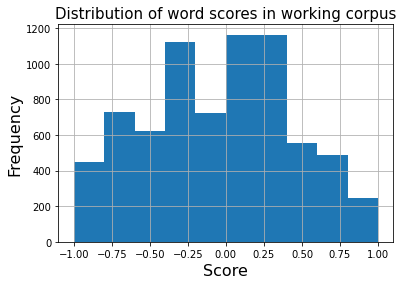

In [13]:
known_words['score'].hist();

plt.title('Distribution of word scores in working corpus', fontsize=15);
plt.xlabel('Score', fontsize=16);
plt.ylabel('Frequency', fontsize=16);

---

Prepare and process data from survey responses. This section may help to identify important unigrams, bigrams and trigrams to include in the lexical corpus

In [14]:
# remove NaN values as empty values
data_responses = data_responses[pd.notna(data_responses['processed comment'])]


In [15]:
# Select comments by classification
satisfaction_good = data_responses[(data_responses['Satisfaction'] == 'good')].reset_index(drop = True)
satisfaction_bad = data_responses[(data_responses['Satisfaction'] == 'bad')].reset_index(drop = True)


In [16]:
# Get tokens by classification
#words =  word_tokenize(satisfaction_good)
#words =  word_tokenize()
word_series = satisfaction_good['processed comment'].reset_index(drop =True)
words_good  = get_unique_tokens(word_series)
word_series = satisfaction_bad['processed comment'].reset_index(drop =True)
words_bad   = get_unique_tokens(word_series)

words_only_bad  = [word for word in words_bad if word not in words_good]
words_only_good = [word for word in words_good if word not in words_bad]

In [17]:
unigrams_good = get_top_n_words(satisfaction_good['processed comment'], 150,1)
bigrams_good  = get_top_n_words(satisfaction_good['processed comment'], 150,2)
trigrams_good = get_top_n_words(satisfaction_good['processed comment'], 150,3)

unigrams_bad  = get_top_n_words(satisfaction_bad['processed comment'], 150,1)
bigrams_bad   = get_top_n_words(satisfaction_bad['processed comment'], 150,2)
trigrams_bad  = get_top_n_words(satisfaction_bad['processed comment'], 150,3)



unigrams_good = [word[0] for word in unigrams_good]
bigrams_good  = [word[0] for word in bigrams_good]
trigrams_good = [word[0] for word in trigrams_good]

unigrams_bad = [word[0] for word in unigrams_bad]
bigrams_bad  = [word[0] for word in bigrams_bad]
trigrams_bad = [word[0] for word in trigrams_bad]


In [18]:
unigrams_keys = [word for word in unigrams_good if word in unigrams_bad]
bigrams_keys  = [word for word in bigrams_good if word in bigrams_bad]
trigrams_keys = [word for word in trigrams_good if word in trigrams_bad]

unigrams_pos = [word for word in unigrams_good if word not in unigrams_bad]
bigrams_pos  = [word for word in bigrams_good if word not in bigrams_bad]
trigrams_pos = [word for word in trigrams_good if word not in trigrams_bad]

unigrams_neg = [word for word in unigrams_bad if word not in unigrams_good]
bigrams_neg  = [word for word in bigrams_bad if word not in bigrams_good]
trigrams_neg = [word for word in trigrams_bad if word not in trigrams_good]

In [19]:
print('Top unigrams_good:')
print(unigrams_pos[:5])
print('Top bigrams_good:')
print(bigrams_pos[:5])
print('Top trigrams_good:')
print(trigrams_pos[:5])

Top unigrams_good:
['excelente', 'bueno', 'buena', 'buen', 'bien']
Top bigrams_good:
['excelente servicio', 'buen servicio', 'buena atención', 'excelente atención', 'mil gracias']
Top trigrams_good:
['servicio muchas gracias', 'excelente muchas gracias', 'excelente servicio gracias', 'buen servicio gracias', 'excelente servicio cliente']


In [20]:
print('Top unigrams_bad:')
print(unigrams_neg[:5])
print('Top bigrams_bad:')
print(bigrams_neg[:5])
print('Top trigrams_bad:')
print(trigrams_neg[:5])

Top unigrams_bad:
['mal', 'dinero', 'malo', 'dirección', 'pésimo']
Top bigrams_bad:
['pésimo servicio', 'mal servicio', 'dado respuesta', 'falta respeto', 'hice pedido']
Top trigrams_bad:
['parece falta respeto', 'nunca recibí respuesta', 'pésimo servicio cliente', 'nunca dieron respuesta', 'mal servicio cliente']


After a careful selection, some of these tokens can be included in the lexical dataset and scores according to the sentiment that they represent

---

## Feature selection

Now we extract the features of comments

In [21]:
data_responses = data_responses.reset_index(drop = True)

vt_comment = []
vt_mean    = []
vt_sum     = []
vt_size    = []
vt_min     = []
vt_max     = []
vt_sentim  = []

nm_lenData = len(data_responses)

for idx in range(0,nm_lenData):
    cur_sent = data_responses.loc[idx,['Satisfaction']].values[0]
    cur_comm = data_responses.loc[idx,['processed comment']].values[0]
    
    features_comment = get_comment_features(cur_comm)
    
    nm_mean = features_comment[0]
    nm_sum  = features_comment[1]
    nm_size = features_comment[2]
    nm_min  = features_comment[3]
    nm_max  = features_comment[4]
    
    vt_comment.append(cur_comm)
    vt_mean.append(nm_mean)
    vt_sum.append(nm_sum)
    vt_size.append(nm_size)
    vt_min.append(nm_min)
    vt_max.append(nm_max)
    vt_sentim.append(cur_sent)
    
features_df = pd.DataFrame({'comment':vt_comment,'mean':vt_mean,'sum':vt_sum,'size':vt_size,
                            'min':vt_min,'max':vt_max,'sentiment':vt_sentim})

In [22]:
print('Total number of good comments:' +str(sum(features_df['sentiment']=='good')))
print('Total number of bad comments:' +str(sum(features_df['sentiment']=='bad')))

features_df


Total number of good comments:6980
Total number of bad comments:3397


,comment,mean,sum,size,min,max,sentiment
0,ya no deseo hacer el pedido es la tercera vez ...,-0.072917,-4.375,60,-1.000,0.375,bad
1,me perdieron como cliente pésimo servicio al c...,-0.229167,-2.750,12,-1.000,0.000,bad
2,ok,0.000000,0.000,1,0.000,0.000,good
3,no recibi respuesta a mi solicitud,-0.277778,-2.500,9,-1.000,0.000,bad
4,me pareció muy buena la atención y ayuda en to...,0.078333,5.875,75,-0.750,1.000,good
...,...,...,...,...,...,...,...
10372,excelente,1.000000,1.000,1,1.000,1.000,good
10373,que al momento de la cancelación del pedido se...,0.032738,1.375,42,-0.375,0.625,good
10374,me enviaron una talla que no pedi,0.027778,0.250,9,-0.500,0.750,bad
10375,la respuesta 5 días después de que llegó el pe...,-0.133333,-2.000,15,-1.000,0.000,bad


Plot distribution of features by class

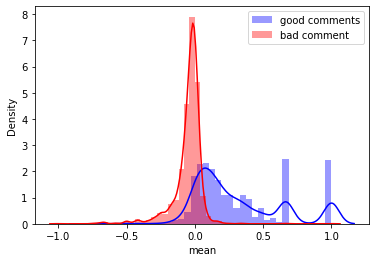

In [23]:
import seaborn as sns
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

sns.distplot( features_df["mean"][features_df["sentiment"] == 'good'] , color="blue", label="good comments")
sns.distplot( features_df["mean"][features_df["sentiment"] == 'bad'] , color="red", label="bad comment")
plt.legend();


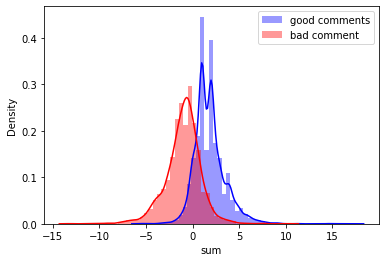

In [24]:
import seaborn as sns

sns.distplot( features_df["sum"][features_df["sentiment"] == 'good'] , color="blue", label="good comments")
sns.distplot( features_df["sum"][features_df["sentiment"] == 'bad'] , color="red", label="bad comment")
plt.legend();

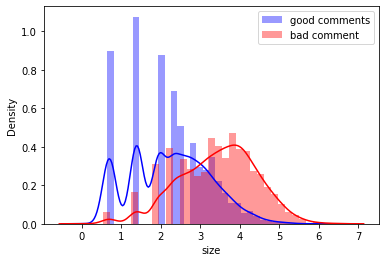

In [25]:
sns.distplot( np.log(features_df["size"][features_df["sentiment"] == 'good']+1) , color="blue", label="good comments")
sns.distplot( np.log(features_df["size"][features_df["sentiment"] == 'bad']+1) , color="red", label="bad comment")
plt.legend();


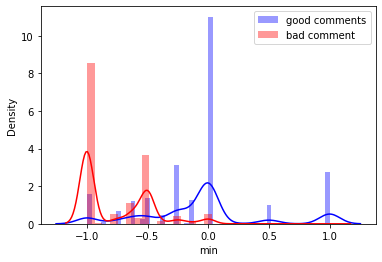

In [26]:
sns.distplot( features_df["min"][features_df["sentiment"] == 'good'] , color="blue", label="good comments")
sns.distplot( features_df["min"][features_df["sentiment"] == 'bad'] , color="red", label="bad comment")
plt.legend();


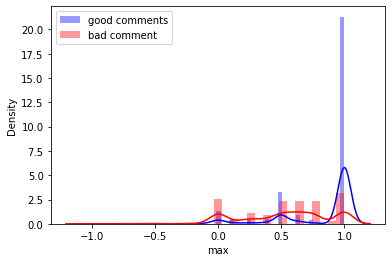

In [27]:
sns.distplot( features_df["max"][features_df["sentiment"] == 'good'] , color="blue", label="good comments")
sns.distplot( features_df["max"][features_df["sentiment"] == 'bad'] , color="red", label="bad comment")
plt.legend();

Determine feature's correlations 

In [28]:
features_df.corr()

,mean,sum,size,min,max
mean,1.000000,0.444712,-0.343926,0.843721,0.555787
sum,0.444712,1.000000,-0.250711,0.443969,0.548566
size,-0.343926,-0.250711,1.000000,-0.495159,0.076068
min,0.843721,0.443969,-0.495159,1.000000,0.324090
max,0.555787,0.548566,0.076068,0.324090,1.000000


Visualizing class distributions by paired features

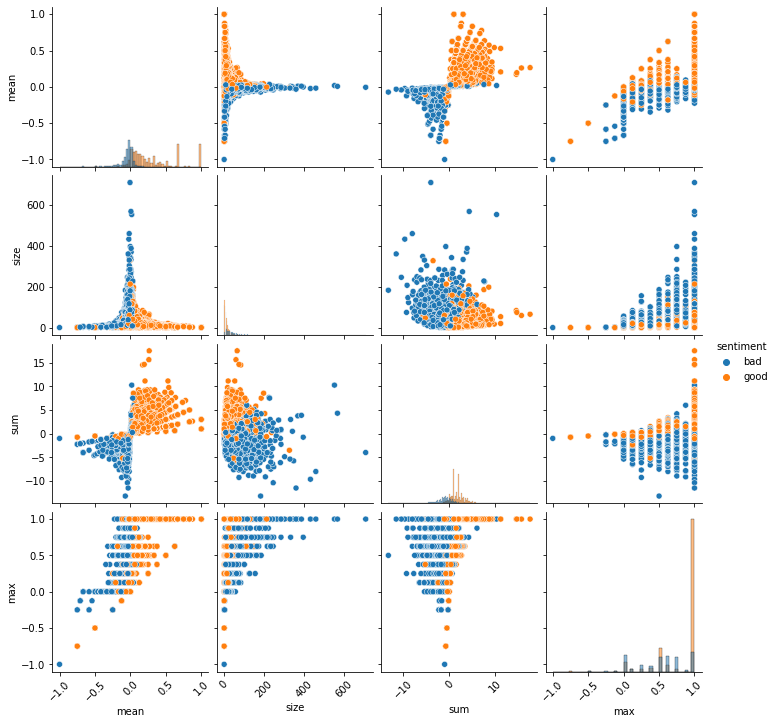

In [29]:
g = sns.pairplot(features_df[["mean", "size", "sum", "max", "sentiment"]], hue="sentiment", diag_kind="hist")
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

There is a class unbalance which is detrimental for training. 

 - Total number of good comments: 6980
 - Total number of bad comments: 3397

Therefore, we can create a subsampling of good comments:  

In [30]:
feat_bad  = features_df[features_df["sentiment"] == 'bad']
feat_good = features_df[features_df["sentiment"] == 'good']
feat_good_sub = feat_good.sample(n = len(feat_bad)).reset_index(drop = True) 
feat_equal= pd.concat([feat_bad,feat_good_sub]).reset_index(drop = True)

print('Total number of instances for classification: '+str(len(feat_equal)))

Total number of instances for classification: 6794


We can visualize that subsampling is not detrimental for class distributions:

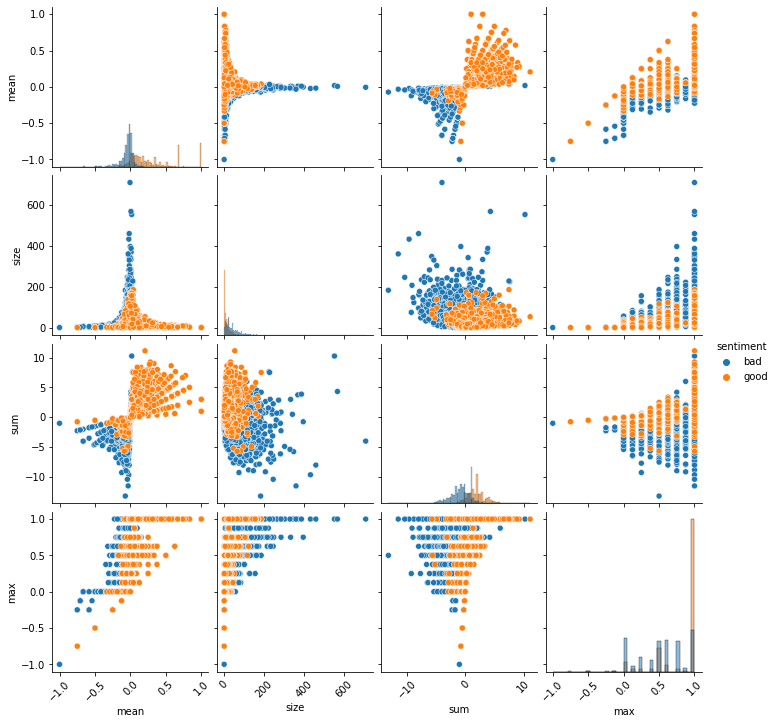

In [31]:
g = sns.pairplot(feat_equal[["mean", "size", "sum", "max", "sentiment"]], hue="sentiment", diag_kind="hist")
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

---

# Model selection

### Training of a logit model & cross-validation:

In [32]:
 # Create a logit model
logit_df = feat_equal[['sentiment',"mean", "size", "sum", "max"]].copy()
logit_df['Intercept'] = 1.0

logit_df["sentiment"] = logit_df["sentiment"].astype('category')
logit_df["size"] = logit_df["size"].astype('float64')


logit_mdl = sm.Logit(logit_df['sentiment'].cat.codes, logit_df[['Intercept',"mean", "size", "sum", "max"]])

logit_res = logit_mdl.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.296690
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 6794
Model:                          Logit   Df Residuals:                     6789
Method:                           MLE   Df Model:                            4
Date:                Mon, 19 Oct 2020   Pseudo R-squ.:                  0.5720
Time:                        16:54:07   Log-Likelihood:                -2015.7
converged:                       True   LL-Null:                       -4709.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3288      0.085      3.847      0.000       0.161       0.496
mean           7.2395      0.678     10.685      0.000       5.912       8.567
size          -0.0356      0.002    -16.695      0.000      -0.040      -0.031
sum            0.8100      0.046     17.510      0.000       0.719       0.901
max           -0.2190      0.156     -1.405      0.160      -0.525       0.086
==============================================================================
"""

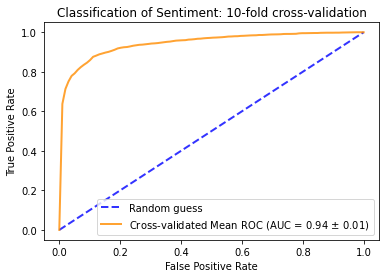

In [33]:
# plot the cross-validated logit ROC

tprs_vs, aucs_vs, mean_fpr_vs = cv_roc_logit(logit_df[['Intercept',"mean", "size", "sum", "max"]], 
                                       logit_df['sentiment'].cat.codes, 10)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_vs = np.mean(tprs_vs, axis=0)
mean_tpr_vs[-1] = 1.0

mean_auc_vs = auc(mean_fpr_vs, mean_tpr_vs)
std_auc_vs = np.std(aucs_vs)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='darkorange', lw=2, alpha=.8,
         label=f"Cross-validated Mean ROC (AUC = {mean_auc_vs:0.2f} $\pm$ {std_auc_vs:0.2f})")

#plt.plot(roc_vs[0], roc_vs[1], color='red', linestyle='--', lw=line_width,
#         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Classification of Sentiment: 10-fold cross-validation')
plt.show()

cv_fpr_logit = mean_fpr_vs 
cv_tpr_logit = mean_tpr_vs
cv_auc_logit = mean_auc_vs
cv_std_logit = std_auc_vs

### Training of a naive-bayes model & cross-validation

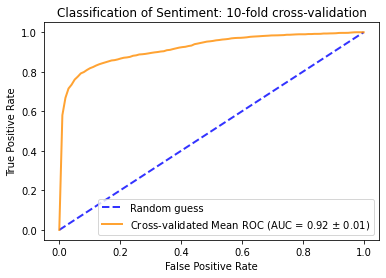

In [34]:
# plot the cross-validated nb ROC

tprs_vs, aucs_vs, mean_fpr_vs = cv_roc_nb(logit_df[['Intercept',"mean", "size", "sum", "max"]], 
                                       logit_df['sentiment'].cat.codes, 10)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_vs = np.mean(tprs_vs, axis=0)
mean_tpr_vs[-1] = 1.0

mean_auc_vs = auc(mean_fpr_vs, mean_tpr_vs)
std_auc_vs = np.std(aucs_vs)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='darkorange', lw=2, alpha=.8,
         label=f"Cross-validated Mean ROC (AUC = {mean_auc_vs:0.2f} $\pm$ {std_auc_vs:0.2f})")

#plt.plot(roc_vs[0], roc_vs[1], color='red', linestyle='--', lw=line_width,
#         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Classification of Sentiment: 10-fold cross-validation')
plt.show()


cv_fpr_nb = mean_fpr_vs 
cv_tpr_nb = mean_tpr_vs
cv_auc_nb = mean_auc_vs
cv_std_nb = std_auc_vs

### Training of a random Forest model & cross-validation

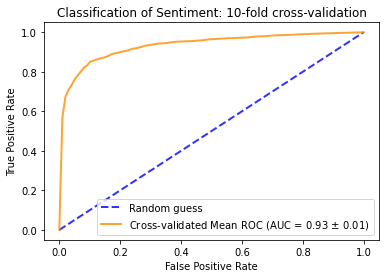

In [35]:
# plot the cross-validated RF ROC

tprs_vs, aucs_vs, mean_fpr_vs = cv_roc_rf(logit_df[['Intercept',"mean", "size", "sum", "max"]], 
                                       logit_df['sentiment'].cat.codes, 10)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_vs = np.mean(tprs_vs, axis=0)
mean_tpr_vs[-1] = 1.0

mean_auc_vs = auc(mean_fpr_vs, mean_tpr_vs)
std_auc_vs = np.std(aucs_vs)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='darkorange', lw=2, alpha=.8,
         label=f"Cross-validated Mean ROC (AUC = {mean_auc_vs:0.2f} $\pm$ {std_auc_vs:0.2f})")

#plt.plot(roc_vs[0], roc_vs[1], color='red', linestyle='--', lw=line_width,
#         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Classification of Sentiment: 10-fold cross-validation')
plt.show()

cv_fpr_rf = mean_fpr_vs 
cv_tpr_rf = mean_tpr_vs
cv_auc_rf = mean_auc_vs
cv_std_rf = std_auc_vs

### Training of a SVM model & cross-validation

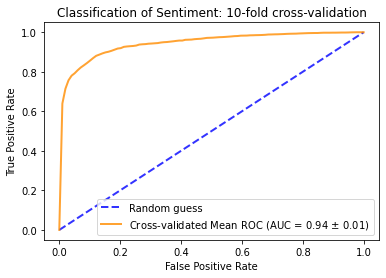

In [36]:
# plot the cross-validated SVM ROC

tprs_vs, aucs_vs, mean_fpr_vs = cv_roc_svm(logit_df[['Intercept',"mean", "size", "sum", "max"]], 
                                       logit_df['sentiment'].cat.codes, 10)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_vs = np.mean(tprs_vs, axis=0)
mean_tpr_vs[-1] = 1.0

mean_auc_vs = auc(mean_fpr_vs, mean_tpr_vs)
std_auc_vs = np.std(aucs_vs)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='darkorange', lw=2, alpha=.8,
         label=f"Cross-validated Mean ROC (AUC = {mean_auc_vs:0.2f} $\pm$ {std_auc_vs:0.2f})")

#plt.plot(roc_vs[0], roc_vs[1], color='red', linestyle='--', lw=line_width,
#         label=f"ROC based on training data (AUC = {auc_vs:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Classification of Sentiment: 10-fold cross-validation')
plt.show()

cv_fpr_svm = mean_fpr_vs 
cv_tpr_svm = mean_tpr_vs
cv_auc_svm = mean_auc_vs
cv_std_svm = std_auc_vs

### Comparing the models AUCs

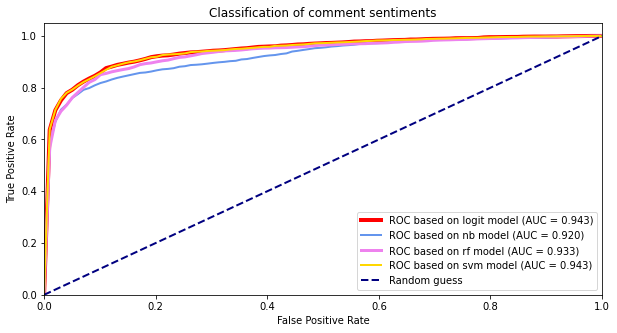

In [37]:
#Plot the ROC curve: (Based in case_9.1)

line_width = 2
plt.figure(figsize=(10,5))
plt.plot(cv_fpr_logit, cv_tpr_logit, color='red', lw=4,
         label=f"ROC based on logit model (AUC = {cv_auc_logit:0.3f})")
plt.plot(cv_fpr_nb, cv_tpr_nb, color='cornflowerblue', lw=line_width,
         label=f"ROC based on nb model (AUC = {cv_auc_nb:0.3f})")
plt.plot(cv_fpr_rf, cv_tpr_rf, color='violet', lw=3,
         label=f"ROC based on rf model (AUC = {cv_auc_rf:0.3f})")
plt.plot(cv_fpr_svm, cv_tpr_svm, color='gold', lw=line_width,
         label=f"ROC based on svm model (AUC = {cv_auc_svm:0.3f})")

plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of comment sentiments')
plt.legend(loc='lower right')
plt.show()